In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor

from statsmodels.tsa.deterministic import DeterministicProcess
from pyearth import Earth

sns.set_style('whitegrid')

df_train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
df_test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')

### Basic pre-procesing of data frames

In [2]:
def data_f(df_new, time_p):
    df_new['cfips'] = df_new['row_id'].str[:-11].astype('int')
    df_new['date'] = pd.to_datetime(df_new['row_id'].str[-10:], dayfirst = True)
    df_new['state'] = df_new['cfips'].div(1000).astype('int')
    df_new['county'] = (df_new['cfips'] - df_new['state'].mul(1000)).astype('int')
    df_new['year'] = df_new['date'].dt.year
    df_new['month'] = df_new['date'].dt.month
    df_new.drop(columns=['row_id', 'first_day_of_month'], inplace=True)
    

    ## Time dummies
    
    start_time_p = pd.date_range(end=time_p[0], periods=2, freq=pd.offsets.MonthBegin(1), closed='right')
    new_time_p = pd.date_range(start=start_time_p[0], periods=len(time_p)*2, freq=pd.offsets.MonthBegin(1), closed='right')
    df_fore = pd.DataFrame(data=np.arange(0,len(time_p)*2-1,1), columns=['time'], index=new_time_p)

    ## Main dataframe with dummies
    df_new = df_new.join(df_fore, how='left', on='date')
    df_new.set_index('date', inplace=True, drop=True)
    
    df_return = df_new[['cfips', 'time', 'state', 'county', 'year', 'month']]
    return df_return

### Pre-processing df_train 

In [3]:
time_p = df_train.first_day_of_month.unique()
df = data_f(df_train.copy().drop(columns=['microbusiness_density', 'active']), time_p)

df['microbusiness_density'] = df_train.microbusiness_density.to_numpy()

# Taking care of df_train outliers
# q_mib_den = df_train['microbusiness_density'].quantile(.98)
# df_train = df_train[df_train['microbusiness_density'] < q_mib_den]

df['microbusiness_density'] = np.log1p(df['microbusiness_density'])
df_mean = df[['time','microbusiness_density']].groupby('time').mean()

In [4]:
# sns.distplot(df['microbusiness_density'])

In [5]:
y_t = np.array(df_mean.microbusiness_density)
dp = DeterministicProcess(index=time_p, order=2)
X_t = dp.in_sample()

# Linear Model
trend_linear = LinearRegression()
trend_linear.fit(X_t, y_t)
pred = trend_linear.predict(X_t)


# # MARS Model
# reg_mars = Earth(penalty = 3, max_degree = 1)
# reg_mars.fit(X_t, y_t)
# pred= reg_mars.predict(X_t)

df_mean['trend'] = pred

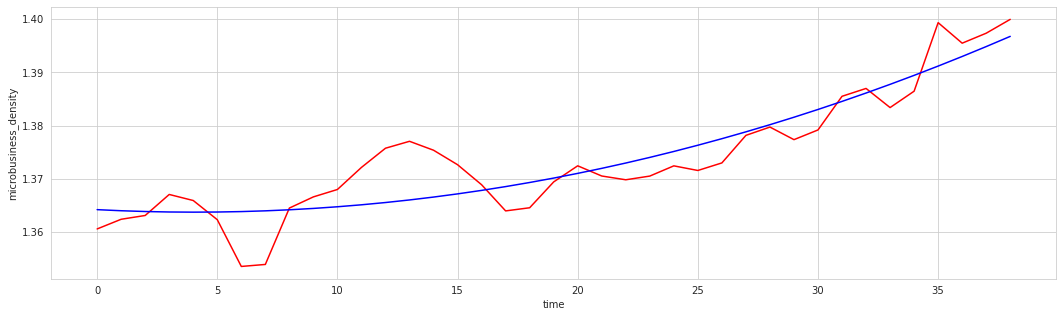

In [6]:
fig, ax = plt.subplots(figsize=[18,5])
ax = sns.lineplot(x=df_mean.index, y=df_mean.microbusiness_density, color='r')
ax = sns.lineplot(x=df_mean.index, y=pred, color='b')

In [7]:
df = df.join(df_mean['trend'].to_frame(), how='left', on='time')
df['detrend'] = df.microbusiness_density - df.trend
df.drop(columns=['microbusiness_density'], inplace=True)

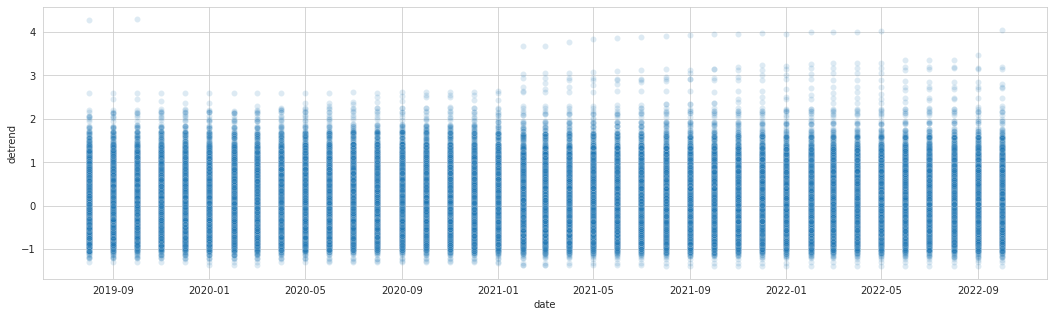

In [8]:
fig, ax = plt.subplots(figsize=[18,5])
ax = sns.scatterplot(data=df.detrend, alpha = 0.15)

### Pre-processing USA-labor data

In [9]:
# df_labor = pd.read_csv('/kaggle/input/monthly-usa-labor-force/labor_force_ver2.csv')
# df_labor['date'] = pd.to_datetime(df_labor['id'].str[:-2], dayfirst = True)

# ## Dummies for gender
# df_labor['gender'] = df_labor['id'].str[-1]
# df_labor = df_labor.join(pd.get_dummies(df_labor['gender'], drop_first = True), how = 'left')
# ## Drop unwanted columns
# df_labor.drop(columns = ['gender', 'id', 'civ_labor_rate', 'civ_employed_rate', 'civ_unemployed_rate', 'civ_not_in_labor_force', 'civ_unemployed_total'], inplace = True)
# df_lab_piv = df_labor.date.loc[df_labor.W == 0].to_frame().copy()

In [10]:
# for el1 in df_labor.drop(columns=['date', 'W']).columns.to_list():
#     df_piv = df_labor[[el1, 'date', 'W']]
#     df_piv = df_labor.pivot(index='date', columns='W', values=el1).reset_index()
#     df_lab_piv[el1+'_m'] = pd.DataFrame(df_piv[[0]].to_numpy())
#     df_lab_piv[el1+'_w'] = pd.DataFrame(df_piv[[1]].to_numpy())
# df_lab_piv.set_index('date', drop=True, inplace=True)
# # df = df.join(df_lab_piv, how='left', on='date')

## Pre-processing Population data

In [11]:
df_pop_features = ['cfips', 'area_land', 'area_water', 'total_population', 'avg_ household_size']
df_pop = pd.read_csv('/kaggle/input/average-household-size-and-population-per-county/Average_Household_Size_and_Population_Density_County.csv', usecols = df_pop_features)
df_pop.set_index('cfips', drop=True, inplace=True)

df_pop['area_land'] = np.log1p(df_pop['area_land'])
df_pop['area_water'] = np.log1p(df_pop['area_water'])
df_pop['total_population'] = np.log1p(df_pop['total_population'])

In [12]:
df = df.join(df_pop, how='left', on='cfips')

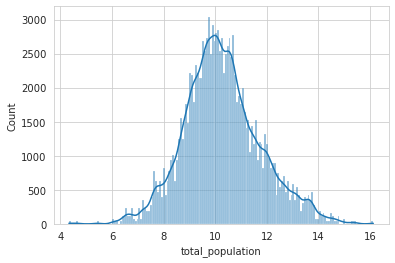

In [13]:
fig, ax = plt.subplots()
ax = sns.histplot(df['total_population'], kde=True)

## Regression

In [14]:
target = 'detrend'
y = np.array(df[target])
X = np.array(df.drop(columns=[target, 'cfips', 'trend']))

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [15]:
# reg_rfr = RandomForestRegressor(random_state=42, max_depth = 1000)
# reg_rfr.fit(X_train, y_train)

from xgboost import XGBRegressor
reg_rfr = XGBRegressor(n_estimators=1000, max_depth=10, eta=0.1)
reg_rfr.fit(X_train, y_train, verbose=False)

pred_rfr = reg_rfr.predict(X_test)
reg_rfr.score(X_test, y_test)

0.9948102828194274

In [16]:
df.drop(columns=[target, 'cfips', 'trend']).head(1)

,time,state,county,year,month,area_land,area_water,avg_ household_size,total_population
date,,,,,,,,,
2019-08-01,0,1,1,2019,8,21.15479,17.062272,2.59,10.918736


In [17]:
#0.994810282819427
#0.994560596886788

In [18]:
df['rfr'] = reg_rfr.predict(X)

df['microbusiness_density'] = np.exp(df.trend + df.rfr) - 1
# df['microbusiness_density'] = df.trend + df.rfr
df.head()

,cfips,time,state,county,year,month,trend,detrend,area_land,area_water,avg_ household_size,total_population,rfr,microbusiness_density
date,,,,,,,,,,,,,,
2019-08-01,1001,0,1,1,2019,8,1.364215,0.023998,21.15479,17.062272,2.59,10.918736,0.016827,2.979043
2019-09-01,1001,1,1,1,2019,9,1.364011,-0.006922,21.15479,17.062272,2.59,10.918736,0.003639,2.926115
2019-10-01,1001,2,1,1,2019,10,1.363865,0.036294,21.15479,17.062272,2.59,10.918736,0.025630,3.012820
2019-11-01,1001,3,1,1,2019,11,1.363776,0.020826,21.15479,17.062272,2.59,10.918736,0.023382,3.003453
2019-12-01,1001,4,1,1,2019,12,1.363744,0.020857,21.15479,17.062272,2.59,10.918736,0.020906,2.993428


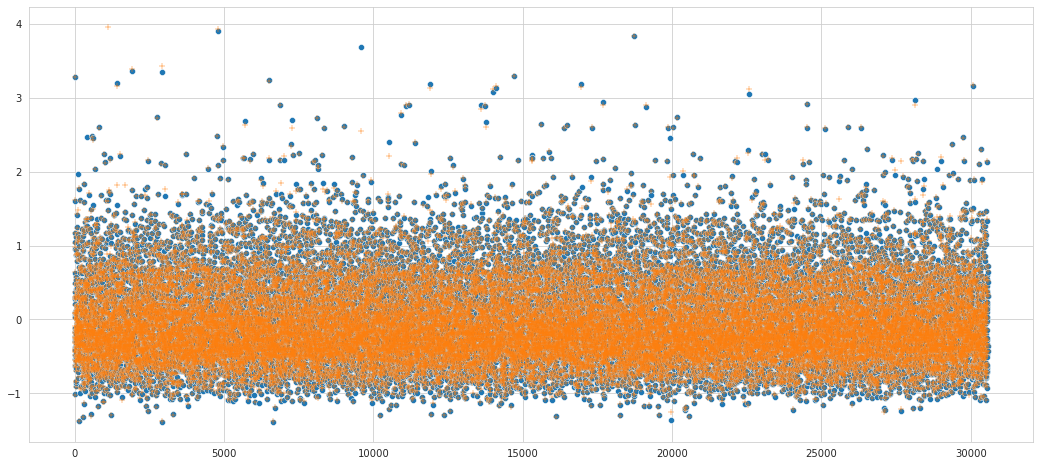

In [19]:
fig, ax = plt.subplots(figsize=[18,8])
ax = sns.scatterplot(data=y_test)
ax = sns.scatterplot(data=pred_rfr, marker='+')

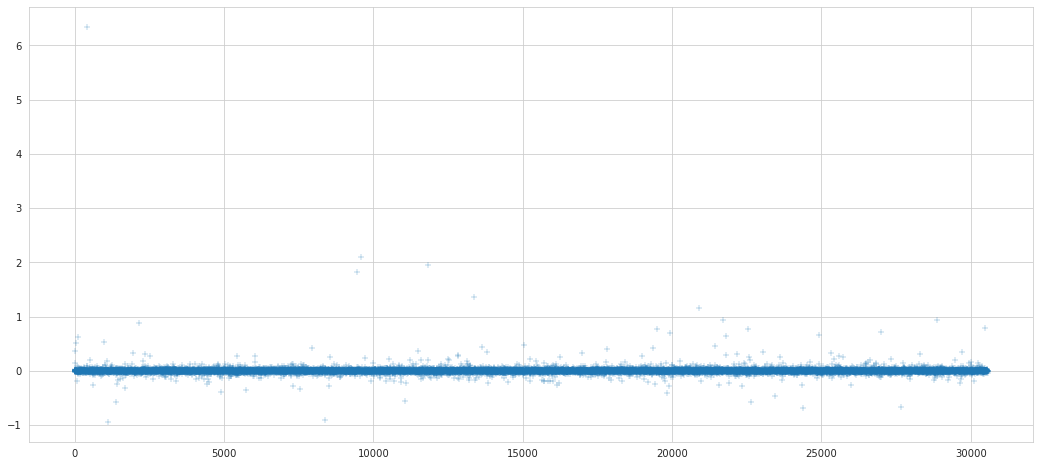

In [20]:
fig, ax = plt.subplots(figsize=[18,8])
ax = sns.scatterplot(data=np.exp(y_test - pred_rfr)-1, alpha = 0.6, marker = "+")
# plt.ylim([-0.5, 0.5])
# plt.xlim([2000,2100])

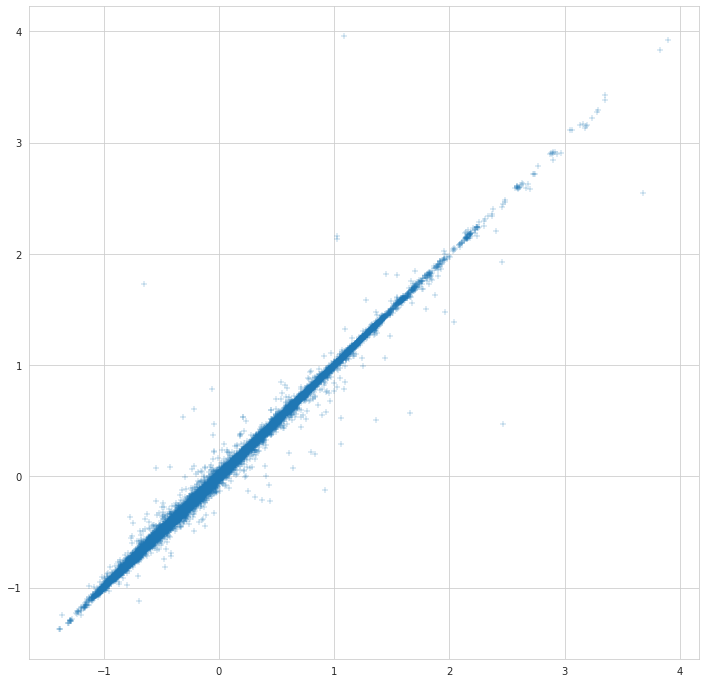

In [21]:
fig, ax = plt.subplots(figsize=[12,12])
ax = sns.scatterplot(x=y_test, y=pred_rfr, alpha = 0.6, marker = "+")

## Forecasting

In [22]:
df_pred = data_f(df_test.copy(), time_p)

In [23]:
df_pred = df_pred.join(df_pop, how='left', on='cfips')

In [24]:
df_pred.head(3)

,cfips,time,state,county,year,month,area_land,area_water,avg_ household_size,total_population
date,,,,,,,,,,
2022-11-01,1001,39,1,1,2022,11,21.154790,17.062272,2.59,10.918736
2022-11-01,1003,39,1,3,2022,11,22.138523,20.848184,2.61,12.245812
2022-11-01,1005,39,1,5,2022,11,21.552754,17.738250,2.49,10.157471


In [25]:
X_fore = dp.out_of_sample(forecast_index=df_pred.index.unique(), steps=8)

pred_fore = pd.DataFrame(trend_linear.predict(X_fore), index=X_fore.index, columns=['trend'])
df_pred = df_pred.join(pred_fore, how='left', on='date')

In [26]:
X_fore_cfips = np.array(df_pred.drop(columns=['cfips', 'trend']))
X_fore_cfips = scaler.transform(X_fore_cfips)
df_pred['rfr'] =reg_rfr.predict(X_fore_cfips)

In [27]:
df_pred['microbusiness_density'] = np.exp(df_pred.trend + df_pred.rfr) - 1

In [28]:
df_pred.loc[df_pred.cfips == 1001]

,cfips,time,state,county,year,month,area_land,area_water,avg_ household_size,total_population,trend,rfr,microbusiness_density
date,,,,,,,,,,,,,
2022-11-01,1001,39,1,1,2022,11,21.15479,17.062272,2.59,10.918736,1.398736,0.097031,3.462757
2022-12-01,1001,40,1,1,2022,12,21.15479,17.062272,2.59,10.918736,1.400767,0.097821,3.475363
2023-01-01,1001,41,1,1,2023,1,21.15479,17.062272,2.59,10.918736,1.402855,0.095970,3.476426
2023-02-01,1001,42,1,1,2023,2,21.15479,17.062272,2.59,10.918736,1.405001,0.096742,3.489509
2023-03-01,1001,43,1,1,2023,3,21.15479,17.062272,2.59,10.918736,1.407205,0.099570,3.512155
2023-04-01,1001,44,1,1,2023,4,21.15479,17.062272,2.59,10.918736,1.409465,0.100966,3.528681
2023-05-01,1001,45,1,1,2023,5,21.15479,17.062272,2.59,10.918736,1.411783,0.099259,3.531450
2023-06-01,1001,46,1,1,2023,6,21.15479,17.062272,2.59,10.918736,1.414158,0.099297,3.542397


In [29]:
# df_train.loc[df_train.cfips == 1001]

In [30]:
df.cfips.unique()

array([ 1001,  1003,  1005, ..., 56041, 56043, 56045])

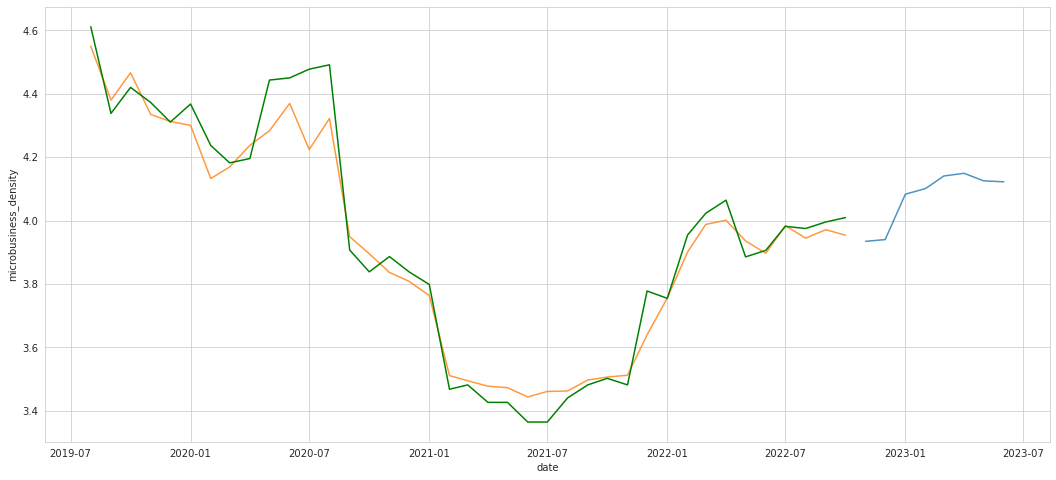

In [31]:
indi = 56041
fig, ax = plt.subplots(figsize=[18,8])

ax = sns.lineplot(data=df_pred.microbusiness_density.loc[df_pred.cfips == indi], alpha = 0.8)
ax = sns.lineplot(data=df.microbusiness_density.loc[df.cfips == indi], alpha = 0.8)
ax = sns.lineplot(x=pd.to_datetime(df_train.first_day_of_month.loc[df_train.cfips == indi], dayfirst=True), y=df_train.microbusiness_density.loc[df_train.cfips == indi], color='g')

### Packing the solution

In [32]:
df_submission = pd.DataFrame(data=df_test.row_id)
df_submission['microbusiness_density'] = df_pred.microbusiness_density.to_numpy()
df_submission.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.462757
1,1003_2022-11-01,8.412797
2,1005_2022-11-01,1.225829
3,1007_2022-11-01,1.291825
4,1009_2022-11-01,1.842104


In [33]:
df_submission.to_csv('submission.csv', index=False)